In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(sec:sql_transforming)=
# Transforming and Common Table Expressions

In this section, we show how to call functions to transform columns of data using built-in SQL functions. We also demonstrate how to use common table expressions to build up complex queries from simpler ones. As usual, we start by loading the database.

In [3]:
# Set up connection to database
import sqlalchemy
db = sqlalchemy.create_engine('sqlite:///babynames.db')

## SQL Functions

SQLite provides a variety of scalar functions, or functions that transform single data
values. When called on a column of data, SQLite will apply these functions on
each value in the column. In contrast, aggregation functions like `SUM` and
`COUNT` take a column of values as input and compute a single value as output.

SQLite provides a comprehensive list of the built-in scalar functions in [its online documentation][funcs]. For instance, to find the number of characters in each name, we use the
`LENGTH` function.

[funcs]: https://www.sqlite.org/lang_corefunc.html

In [4]:
query = ''' 
SELECT Name, LENGTH(Name)
FROM baby
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,LENGTH(Name)
0,Liam,4
1,Noah,4
2,Oliver,6
...,...,...
7,Lucas,5
8,Henry,5
9,Alexander,9


Notice that the `LENGTH` function is applied to each value within the `Name`
column. 

:::{note}

Like aggregation functions, each implementation of SQL provides a different set
of scalar functions. SQLite has a relatively minimal set of functions, while
[PostgreSQL has many more][pg_funcs]. That said, almost all SQL implementations provide some
equivalent to SQLite's `LENGTH`, `ROUND`, `SUBSTR`, and `LIKE` functions. 

:::

[pg_funcs]: https://www.postgresql.org/docs/9.2/functions.html

Although scalar functions use the same syntax as an aggregation function, they behave differently. This
can result in confusing output if the two are mixed together in a single query:

In [12]:
query = ''' 
SELECT Name, LENGTH(Name), AVG(Count)
FROM baby
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,LENGTH(Name),AVG(Count)
0,Liam,4,174.47


Here, the `AVG(Name)` computes the average of the entire `Count` column, but the output is confusing---a reader could easily think the average is related to the name `Liam`. For this reason, we must be careful when when scalar and aggregation functions
appear together within a `SELECT` statement. 

To extract the first letter of each name, we can use the `SUBSTR` function
(short for "substring"). As described in the documentation, the `SUBSTR`
function takes three arguments. The first is the input string, the second is
the position to begin the substring (1-indexed), and the third is the
length of the substring.

In [11]:
query = ''' 
SELECT Name, SUBSTR(Name, 1, 1)
FROM baby
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,"SUBSTR(Name, 1, 1)"
0,Liam,L
1,Noah,N
2,Oliver,O
...,...,...
7,Lucas,L
8,Henry,H
9,Alexander,A


We can use the `AS` keyword to rename the column:

In [12]:
query = ''' 
SELECT *, SUBSTR(Name, 1, 1) AS Firsts
FROM baby
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year,Firsts
0,Liam,M,19659,2020,L
1,Noah,M,18252,2020,N
2,Oliver,M,14147,2020,O
...,...,...,...,...,...
7,Lucas,M,11281,2020,L
8,Henry,M,10705,2020,H
9,Alexander,M,10151,2020,A


This completes step 1 of our analysis plan. SQL provides several options to
break queries into smaller steps, which is helpful in a more complex analysis
like this one. One option is to create an entirely new relation using the
`CREATE TABLE` statement. Another option is to use the `WITH` keyword to
create a temporary relation just for the query at hand. We'll demonstrate 
the `WITH` keyword for this example.

## Multistep Queries Using a `WITH` Clause

The `WITH` clause lets us assign a name to any `SELECT` query. Then, we can
treat that query as though it exists as a relation in the database. For
instance, we can take the query above that calculates the first letter of each
name and call it `letters`:

In [13]:
query = ''' 
WITH letters AS (
  SELECT *, SUBSTR(Name, 1, 1) AS Firsts
  FROM baby
)
SELECT *
FROM letters
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year,Firsts
0,Liam,M,19659,2020,L
1,Noah,M,18252,2020,N
2,Oliver,M,14147,2020,O
...,...,...,...,...,...
7,Lucas,M,11281,2020,L
8,Henry,M,10705,2020,H
9,Alexander,M,10151,2020,A


We can read this query as follows:

```sql
-- Create a temporary relation called letters by calculating the first
-- letters for each name in baby
WITH letters AS (               
  SELECT *,   
    SUBSTR(Name, 1, 1) AS Firsts 
  FROM baby
)
-- Then, select the first ten rows from letters
SELECT *
FROM letters
LIMIT 10;
```

`WITH` statements are highly useful since they can be chained together. We can
create multiple temporary relations in a `WITH` statement that each perform a
bit of work on the previous result, which lets us gradually build complicated
queries a step at a time. 

## Example: Popularity of "L" Names

Now, we can perform the next steps in our analysis. We'll group the relation by the
first letter and year, then aggregate the `Count` column using a sum.

In [14]:
query = ''' 
WITH letters AS (
  SELECT *, SUBSTR(Name, 1, 1) AS Firsts
  FROM baby
)
SELECT Firsts, Year, SUM(Count) AS Count
FROM letters
GROUP BY Firsts, Year;
'''

letter_counts = pd.read_sql(query, db)
letter_counts

,Firsts,Year,Count
0,A,1880,16740
1,A,1881,16257
2,A,1882,18790
...,...,...,...
3638,Z,2018,55996
3639,Z,2019,55293
3640,Z,2020,54011


Finally, we use `plotly` to plot the popularity of "L" names over time:

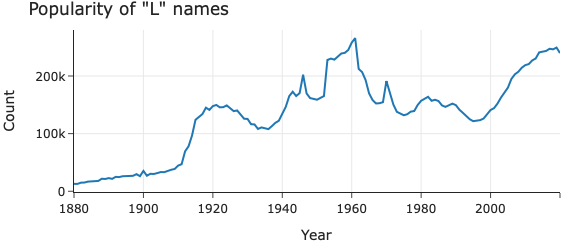

In [17]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'L'],
              x='Year', y='Count', title='Popularity of "L" names',
              width=350, height=250)
margin(fig, t=30)

The plot shows that "L" names were popular in the 1960s, dipped in the decades
after, but have indeed resurged in popularity after 2000. 

What about "J" names?

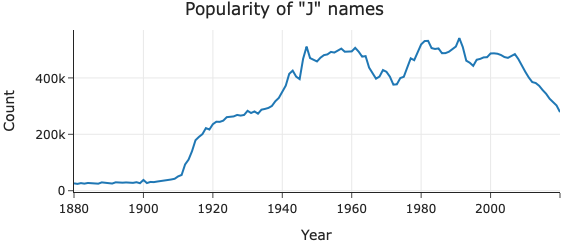

In [24]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'J'],
              x='Year', y='Count', title='Popularity of "J" names',
              width=350, height=250)
margin(fig, t=30)

The NYT article says that "J" names were popular in the 1970s and 80s. The plot
agrees, and also shows that they have become less popular after 2000.

In this section, we introduced data transformations.
To transform values in a relation, we commonly use SQL functions like
`LENGTH()` or `SUBSTR()`.
We also explained how to build up complex queries using the `WITH` clause.
In the next section, we'll compare relations with other ways to represent and
manipulate data tables.